In [1]:
from fastai.vision import * #import from vision to use the classification interpreter
from pathlib import Path
import pdb
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from timeseries import TimeSeriesItem, TimeSeriesList, UCRArchive

In [2]:
ucr = UCRArchive()

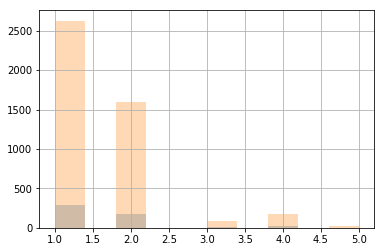

In [3]:
dataset_name = "ECG5000"
vc = ucr.category_distribution(dataset_name)

In [4]:
data = (TimeSeriesList.from_csv_list(ucr.get_csv_files(dataset_name),labelCol=0)
                      .split_by_csv_name([f"{dataset_name}_TEST.tsv"])
                      .label_from_col())
dslen = min(len(data.train),len(data.valid))
bs = min(64,dslen//10)
data = data.databunch(bs=bs,num_workers=0)

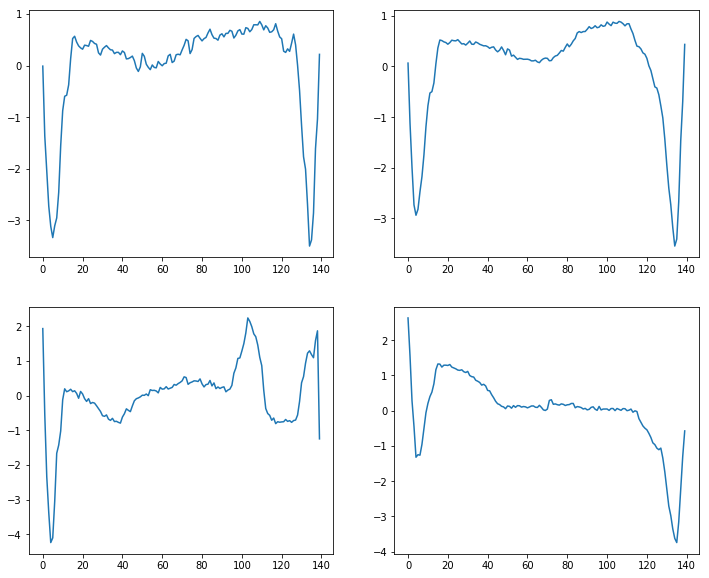

In [5]:
data.show_batch()

In [32]:
class TSClassifier(torch.nn.Module):
    def __init__(self,seqLen,numClasses):
        super().__init__()
        self.conv = WideResNet1d(3,3,6)
        self.hidden= torch.nn.Linear(self.conv.nf,300)
        self.out = torch.nn.Linear(300,numClasses)
              
    def forward(self,ts):
        ts = self.conv(ts.unsqueeze(1))
        return self.out(torch.relu(self.hidden(ts)))

In [33]:
#Create a fastai learner
learn = Learner(data,TSClassifier(len(data.train_ds[0][0].data),data.train_ds.c),loss_func=F.cross_entropy,metrics=[accuracy])

In [34]:
# Run one batch through the model to make sure the output size is correct
learn.model(next(iter(data.train_dl))[0]).size()

torch.Size([50, 5])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


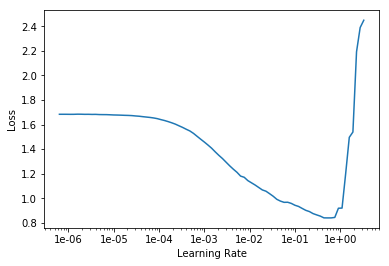

In [57]:
#Learning rate finder
learn.lr_find()
learn.recorder.plot()

In [49]:
learn.to_fp16();

In [36]:
learn.fit_one_cycle(10,1e-3,wd=0.2)

epoch,train_loss,valid_loss,accuracy
1,0.136663,0.273333,0.927778
2,0.133422,0.265800,0.928222
3,0.132697,0.264317,0.927556
4,0.130155,0.269923,0.927333
5,0.127236,0.275078,0.927111
6,0.124305,0.274725,0.927778
7,0.123497,0.275558,0.928000
8,0.122198,0.277321,0.928000
9,0.119901,0.277633,0.927778
10,0.118721,0.278972,0.927778


In [12]:
dataAE = (TimeSeriesList.from_csv_list(ucr.get_csv_files(dataset_name),labelCol=0)
                        .random_split_by_pct(0.05) #use both train and validation data
                        .label_from_self() #use input as output target
                        .databunch(bs=bs,num_workers=0)) #bug on windows if num_workers is higher than 0

In [173]:
# dataAE = (TimeSeriesList.from_numpy(np.random.rand(10000,1)*np.sin(np.random.rand(10000,1)*2*np.pi*np.linspace(0,2*np.pi,96)))
#                         .random_split_by_pct() #use both train and validation data
#                         .label_from_self() #use input as output target
#                         .databunch(num_workers=0)) #bug on windows if num_workers is higher than 0

In [13]:
class TSAE(torch.nn.Module):
    def __init__(self,seqLen,latentDim=24):
        super().__init__()
        #self.conv = ConvBase(seqLen)
        self.conv = WideResNet1d(3,3,6)
        self.mean = torch.nn.Linear(self.conv.nf,latentDim)
        self.logvar = torch.nn.Linear(self.conv.nf,latentDim)
        

        layers = []
        for a,b in [(latentDim,100),(100,200),(200,300)]:
            layers += bn_drop_lin(a,b,actn=torch.nn.ReLU())
        self.lin = torch.nn.Sequential(*layers)
        self.out = torch.nn.Linear(300,seqLen)

    def forward(self,ts):
        seqLen = ts.shape[1]
        ts = self.conv(ts.unsqueeze(1)).squeeze(-1)
        #mean, logvar = self.mean(ts), self.logvar(ts)
        mean = self.mean(ts)
        
        ls = mean
#         if self.training:
#             std = torch.exp(0.5 * logvar)
#             eps = torch.randn_like(std)
#             ls = eps.mul(std).add_(mean)
        return self.out(self.lin(ls))          
        #return self.out(self.lin(ls)), mean, logvar

In [14]:
class VAELoss(torch.nn.Module):
    def forward(self,p,target):
        pred,mean,logvar = p
        self.mse = torch.nn.functional.mse_loss(pred,target,reduction="sum")
        self.kld = -0.5 * torch.sum(1+logvar-mean.pow(2)-logvar.exp())
        return self.mse + self.kld

In [15]:
class PrintLosses(LearnerCallback):
    _order=-20
    def __init__(self,learn):
        super().__init__(learn)
    def on_train_begin(self, **kwargs):
        self.learn.recorder.add_metric_names(["mse","kld"])
    def on_epoch_end(self, **kwargs):
        self.learn.recorder.add_metrics([self.learn.loss_func.mse,self.learn.loss_func.kld])

In [16]:
learnAE = Learner(dataAE,TSAE(len(data.train_ds[0][0].data)),loss_func=F.mse_loss)#,loss_func=VAELoss(),callback_fns=PrintLosses)

In [17]:
learnAE.model(next(iter(data.train_dl))[0]).size()

torch.Size([50, 140])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


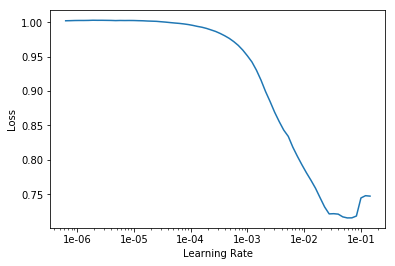

In [18]:
learnAE.lr_find()
learnAE.recorder.plot()

In [19]:
learnAE.fit_one_cycle(10,1e-2)

epoch,train_loss,valid_loss
1,0.217841,0.367840
2,0.117195,0.492427
3,0.095867,0.262321
4,0.073170,0.169749
5,0.061890,0.130766
6,0.051210,0.065096
7,0.043751,0.037972
8,0.036328,0.028868
9,0.029466,0.021826
10,0.027398,0.020403


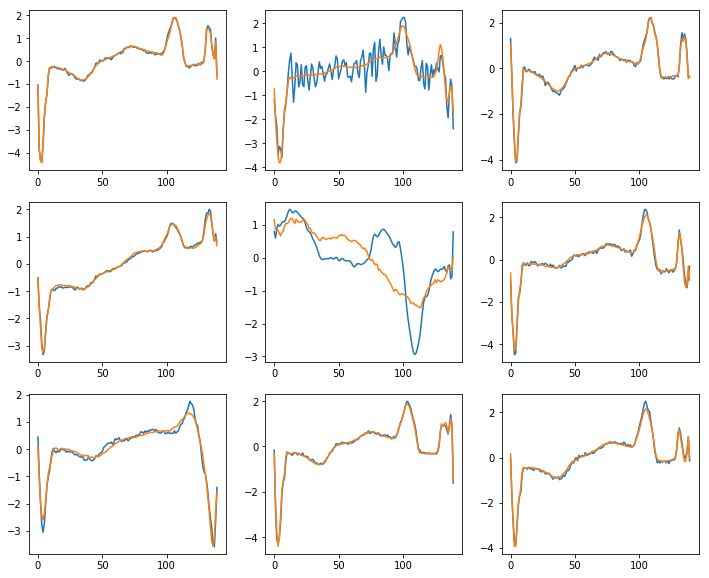

In [20]:
learnAE.show_results(DatasetType.Train,rows=9)

In [21]:
learnAE.model.eval()
out = []
classes = []
with torch.no_grad():
    for x,y in iter(data.valid_dl):
        ls = learnAE.model.mean(learnAE.model.conv(x.unsqueeze(1)).squeeze(-1))
        out.append(ls)
        classes.append(y)
out = torch.cat(out).cpu().detach().numpy()
classes = torch.cat(classes).cpu().detach().numpy()

In [22]:
np.bincount(classes)

array([2627, 1590,   86,  175,   22], dtype=int64)

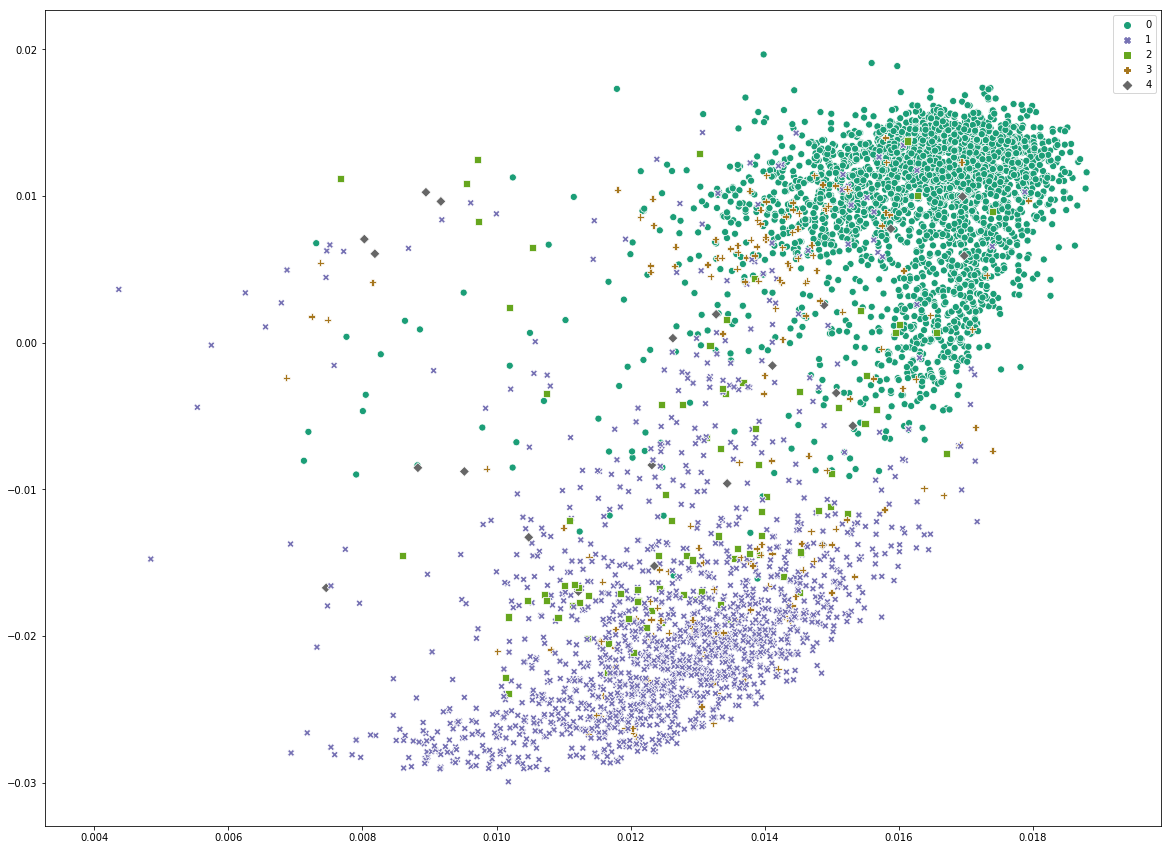

In [23]:
pca = PCA(n_components=2)
f = pca.fit(out.T)
f = f.components_.T
plt.subplots(figsize=(20,15))
sns.scatterplot(x=f[:,0],y=f[:,1],hue=classes,palette="Dark2",style=classes,legend="full",s=50)

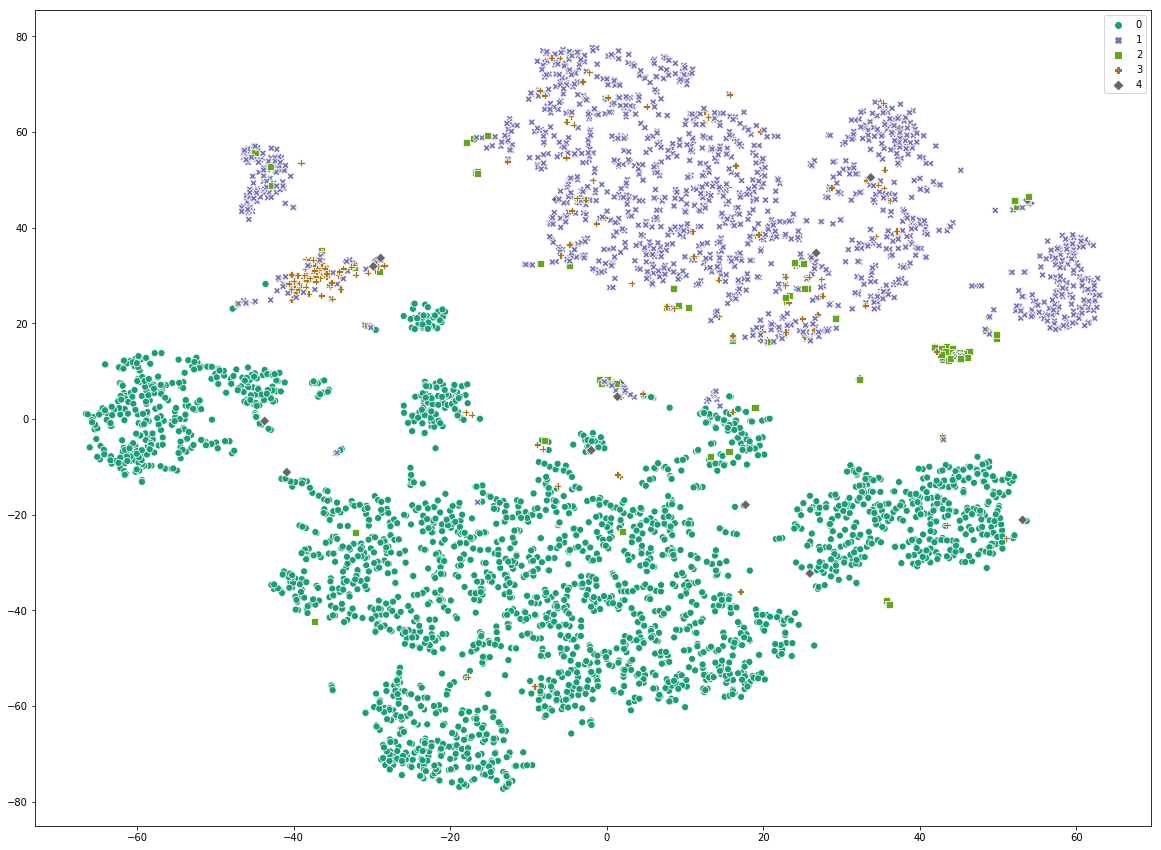

In [24]:
tsne = TSNE(n_components=2)
f = tsne.fit_transform(out)
plt.subplots(figsize=(20,15))
sns.scatterplot(x=f[:,0],y=f[:,1],hue=classes,palette="Dark2",style=classes,legend="full",s=50)

In [28]:
learnDT = Learner(data,TSClassifier(len(data.train_ds[0][0].data),data.train_ds.c),loss_func=F.cross_entropy,metrics=[accuracy],
                 callback_fns=BnFreeze,bn_wd=False,train_bn=False)
learnDT.split(split_model(learnDT.model,[*learnDT.model.conv.split_groups,learnDT.model.out]))

In [29]:
learnDT.model.conv.load_state_dict(learnAE.model.conv.state_dict())

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


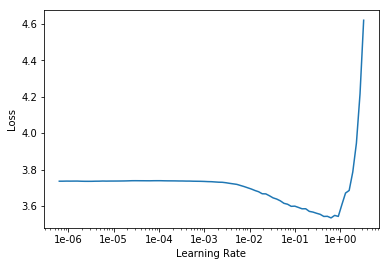

In [82]:
learnDT.lr_find()
learnDT.recorder.plot()

In [30]:
learnDT.freeze_to(-1)
learnDT.fit_one_cycle(10,1e-2)

epoch,train_loss,valid_loss,accuracy
1,1.585652,1.478978,0.583778
2,1.424971,1.060011,0.583778
3,1.217451,0.814358,0.583778
4,1.065168,0.715325,0.805333
5,0.951933,0.647668,0.883556
6,0.865073,0.604583,0.887333
7,0.796384,0.578906,0.892000
8,0.742152,0.564372,0.900222
9,0.699873,0.559088,0.900444
10,0.667123,0.558216,0.900889


In [31]:
learnDT.unfreeze()
learnDT.fit_one_cycle(10,slice(1e-5,1e-2))

epoch,train_loss,valid_loss,accuracy
1,0.489677,0.406119,0.912889
2,0.416178,0.296046,0.918222
3,0.347728,0.261379,0.926222
4,0.302369,0.268565,0.926000
5,0.269724,0.217334,0.936667
6,0.245247,0.254231,0.936444
7,0.226040,0.206499,0.937111
8,0.206439,0.219357,0.939333
9,0.189868,0.210984,0.940444
10,0.176011,0.209637,0.941333


In [39]:
class TSClassifierTransfer(torch.nn.Module):
    def __init__(self,seqLen,numClasses):
        super().__init__()
        self.conv_pretrained = WideResNet1d(3,3,6)
        self.conv_random = WideResNet1d(3,3,6)
        
        self.out = torch.nn.Linear(self.conv_pretrained.nf + self.conv_random.nf,numClasses)
        
    def forward(self, ts):
        tsp = self.conv_pretrained(ts.unsqueeze(1))
        tsr = self.conv_random(ts.unsqueeze(1))
        ts = torch.cat([tsp,tsr],dim=1)   
            
        return self.out(ts)

In [49]:
learnTransfer = Learner(data,TSClassifierTransfer(len(data.train_ds[0][0].data),data.train_ds.c),
                        loss_func=F.cross_entropy,metrics=[accuracy],callback_fns=BnFreeze,bn_wd=False,train_bn=False)
learnTransfer.split(split_model(learnTransfer.model,[learnTransfer.model.conv_pretrained,learnTransfer.model.conv_random,learnTransfer.model.out]))

In [50]:
learnTransfer.model.conv_pretrained.load_state_dict(learnAE.model.conv.state_dict())

In [47]:
learnTransfer.model(next(iter(data.train_dl))[0]).size()

torch.Size([50, 5])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


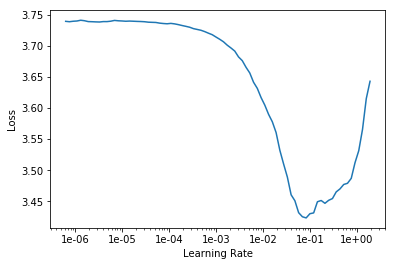

In [90]:
learnTransfer.lr_find()
learnTransfer.recorder.plot()

In [51]:
learnTransfer.freeze_to(1)

In [52]:
learnTransfer.fit_one_cycle(10,1e-3,wd=0.2)

epoch,train_loss,valid_loss,accuracy
1,1.602252,1.584624,0.583556
2,1.321155,1.344344,0.357333
3,0.988104,0.741631,0.903111
4,0.764156,0.298809,0.926667
5,0.614825,0.334297,0.923333
6,0.510842,0.260584,0.929333
7,0.432193,0.271040,0.930889
8,0.372625,0.260039,0.927778
9,0.328618,0.253932,0.929778
10,0.293153,0.253402,0.929333


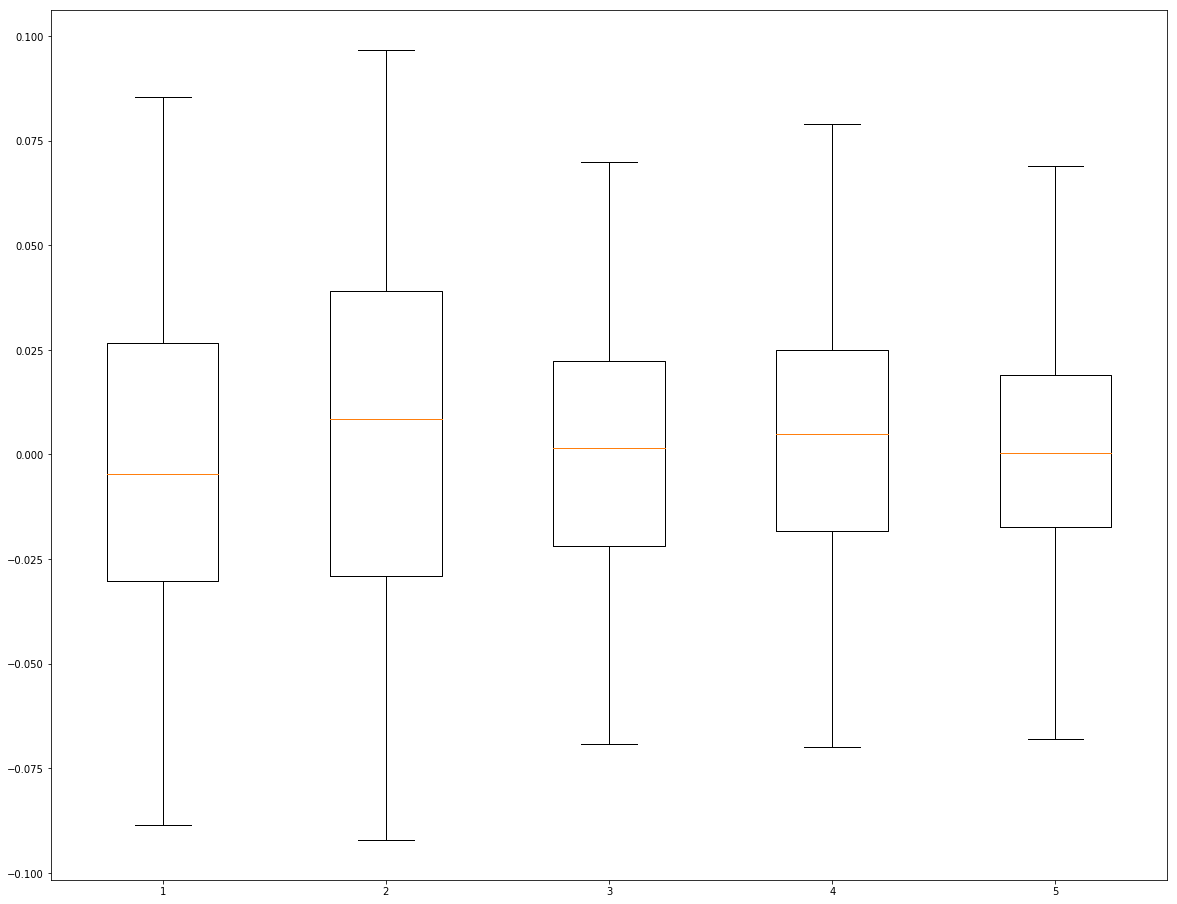

In [53]:
w = learnTransfer.model.out.weight.cpu().detach().numpy()
c = w.shape[1] // 2
p,r = w[:,:c],w[:,c:]
_,ax = plt.subplots(figsize=(20,16))
ax.boxplot((p-r).T);

In [7]:
def conv1d(ni:int, nf:int, ks:int=3, stride:int=1, padding:int=None, bias=False, init:LayerFunc=nn.init.kaiming_normal_) -> nn.Conv1d:
    "Create and initialize `nn.Conv1d` layer. `padding` defaults to `ks//2`."
    if padding is None: padding = ks//2
    return init_default(nn.Conv1d(ni, nf, kernel_size=ks, stride=stride, padding=padding, bias=bias), init)

def _bn1d(ni, init_zero=False):
    "Batchnorm layer with 0 initialization"
    m = nn.BatchNorm1d(ni)
    m.weight.data.fill_(0 if init_zero else 1)
    m.bias.data.zero_()
    return m

def bn_relu_conv1d(ni, nf, ks, stride, init_zero=False):
    bn_initzero = _bn1d(ni, init_zero=init_zero)
    return nn.Sequential(bn_initzero, nn.ReLU(inplace=True), conv1d(ni, nf, ks, stride))

class ResBlock(torch.nn.Module):
    def __init__(self, ni, nf, stride, drop_p=0.0):
        super().__init__()
        self.bn = nn.BatchNorm1d(ni)
        self.conv1 = conv1d(ni, nf, 3, stride)
        self.conv2 = bn_relu_conv1d(nf, nf, 3, 1)
        self.drop = nn.Dropout(drop_p, inplace=True) if drop_p else None
        self.shortcut = conv1d(ni, nf, 1, stride) if ni != nf else noop

    def forward(self, x):
        x2 = F.relu(self.bn(x), inplace=True)
        r = self.shortcut(x2)
        x = self.conv1(x2)
        if self.drop: x = self.drop(x)
        x = self.conv2(x) * 0.2
        return x.add_(r)

def _make_group(N, ni, nf, block, stride, drop_p):
    return [block(ni if i == 0 else nf, nf, stride if i == 0 else 1, drop_p) for i in range(N)]

class WideResNet1d(nn.Module):
    "Wide ResNet with `num_groups` and a width of `k`."
    def __init__(self, num_groups:int, N:int, k:int=1, drop_p:float=0.0, start_nf:int=16,maxY=20.0):
        super().__init__()
        self.maxY = maxY
        n_channels = [start_nf]
        for i in range(num_groups): n_channels.append(start_nf*(2**i)*k)
        
        
        layers = [conv1d(1, n_channels[0], 3, 1)]  # conv1
        self.split_groups = [layers[-1]] 
        
        for i in range(num_groups):
            layers += _make_group(N, n_channels[i], n_channels[i+1], ResBlock, (1 if i==0 else 2), drop_p)
            self.split_groups.append(layers[-N])
            
        layers += [nn.BatchNorm1d(n_channels[-1]), nn.ReLU(inplace=True), nn.AdaptiveAvgPool1d(1),
                   Flatten()]
        #self.split_groups.append(layers[-1])
        self.nf = n_channels[-1]
        self.features = nn.Sequential(*layers)

    def forward(self, x):
        #x = x.unsqueeze(1)
        return self.features(x)